In [2]:
import urllib.request as urllib
import io
import zipfile
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

# download the data from the internet

In [3]:
url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open an url
s = io.BytesIO(sock.read())  # read BytesIO file
sock.close()

zf = zipfile.ZipFile(s)  # ZipFile object
# txt = zf.read('football.txt').decode()  # read txt
gml = zf.read('football.gml').decode()  #  read gml data
# delete the first line
gml = gml.split('\n')[1:]
G = nx.parse_gml(gml)  # release gml数据
'''-----------------read data over-------------------'''
# print(txt)
# 打印每个队的度——比赛的数量
# for n, d in G.degree():
#     print('%s %d' % (n, d))

'-----------------read data over-------------------'

# visualize the graph

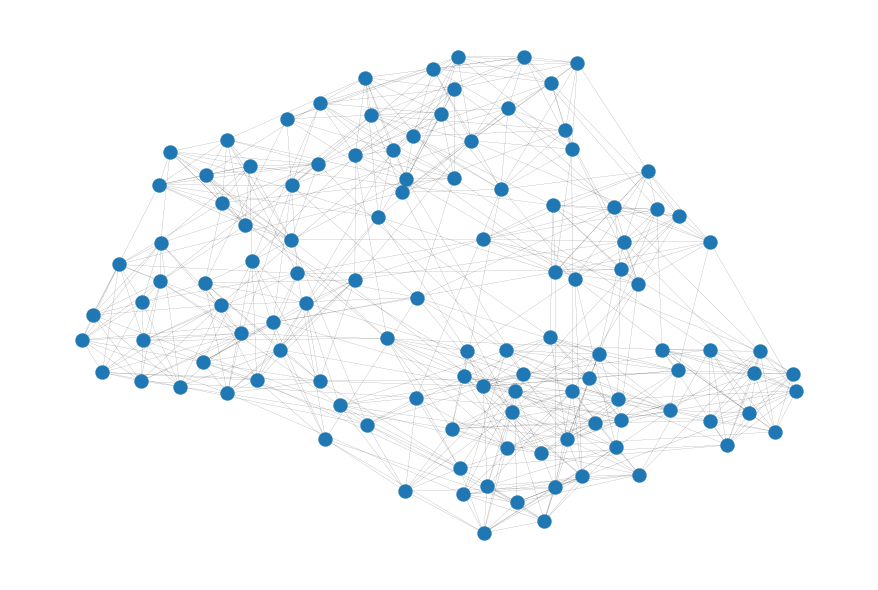

In [4]:
options = {
    # 'node_color': 'black',
    'node_size': 200,
    # 'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.1,
}
# Find key-values for the graph
pos = nx.spring_layout(G)
plt.figure(figsize=[12,8])
nx.draw(G, **options,cmap = plt.get_cmap('rainbow'), pos=pos, with_labels=False)

# print information of the graph

In [5]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes :", str(n))
print("Number of edges :", str(m))
print("Number of connected components :" ,str(nx.number_connected_components(G)))


Number of nodes : 115
Number of edges : 613
Number of connected components : 1


对于无向图而言，115个节点理论上能产生$115*(115-1)/2=6555$条边

那么$D_1$=613，$D_2$=6555-613=5942

首先，先把$D_1$和$D_2$边数据集构造出来

##  构建$D1$,$D2$

In [6]:
D1=list(G.edges)

node_list=list(G.nodes)
D2=[]
for i in range(len(node_list)):
    for j in range(i+1,len(node_list)):
        source,target=node_list[i],node_list[j]
        D2.append((source,target))

In [7]:
D2 = list(set(D2) - set(D1))
print('不存在的边的数量: ',len(D2))
print('存在的边的数量: ',len(D1))
print('D1, D2集合的相同边: ',len(set(D2)&set(D1)))

不存在的边的数量:  5942
存在的边的数量:  613
D1, D2集合的相同边:  0


如上所示，我们将存在的边表示为D1，将不存在的边表示为D2

#  分割D1为L_train,L_test,分割D2为L_ptrain,L_ptest

In [29]:
# 随机将list按7:3的比例进行划分
import random

def split_(full_list, shuffle=False, ratio=0.3):
    n_total = len(full_list)
    offset = int(n_total*ratio)
    if n_total==0 or offset<1:
        return [], full_list
    if shuffle:
        random.shuffle(full_list)
    sublist_train = full_list[offset:]
    sublist_test = full_list[:offset]
    return sublist_train, sublist_test

L_train, L_test = split_(D1)
L_ptrain, L_ptest = split_(D2)

print('L_train: ',len(L_train))
print('L_test: ',len(L_test))
print('L_ptrain: ',len(L_ptrain))
print('L_ptest: ',len(L_ptest))

L_train:  430
L_test:  183
L_ptrain:  4160
L_ptest:  1782


构造测试集

In [31]:
from random import sample
L_ptest_sample = sample(L_ptest,len(L_test))
Data_test = L_test+L_ptest_sample
random.shuffle(Data_test)
print('Data_test: ',len(Data_test))

Data_test:  366


构造多个训练集

In [43]:
# 从不存在边中采样K次，每次与D1的训练集进行混合得到平衡的训练数据
nums_Dk=10# 构建nums_Dk组数据集
Train_list = []
# 没有设置随机种子，每次的抽样结果都是不同的
for i in range(nums_Dk):
    L_ptrain_sample=sample(L_ptrain,len(L_train))
    L_ptrain_sample.extend(L_train)
    random.shuffle(L_ptest_sample)
    Train_list.append(L_ptrain_sample)

print('L_ptrain_i: ', len(Train_list[0]))

L_ptrain_i:  860


# 提取特征

In [38]:
class FunctionSet:
    def __init__(self,G,Beta=1.84):
        '''
        β是超参数，论文的β为1.84和1.76
        '''
        self.G=G
        self.C=nx.average_clustering(G)
        self.function_list=[getattr(self, name) for name in dir(self) if name[0]!='_' and hasattr(getattr(self, name),'__call__')]
        self.function_name=[func.__name__ for func in self.function_list]
        self.Beta=Beta
    def _run_all(self,Dk,type=1):
        source=np.array([x[0] for x in Dk])[:,np.newaxis]
        target=np.array([x[1] for x in Dk])[:,np.newaxis]
        class_=np.array([type]*len(Dk))[:,np.newaxis]
        feature_data=np.array([[func(edge[0],edge[1]) for func in self.function_list] for edge in Dk])
        feature_data=np.hstack((np.hstack((np.hstack((source,target)),class_)),feature_data))
        feature_column=['source','target','class']+self.function_name
        df_Dk=pd.DataFrame(data=feature_data,columns=feature_column)
        return df_Dk
    # L(z) 计算
    def _L(self,z,common_neighbor):
        return sum(self.G.has_edge(z,w) for w in set(common_neighbor)-set([z]))
    # Jaccard 计算
    def Jaccard(self,u, v):
        union_size = len(set(self.G[u]) | set(self.G[v]))# 取并集
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(self.G, u, v))) / union_size# 交集/并集
    # Common neighbor计算
    def CN(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v)))
    # adamic_adar计算
    def AA(self,u,v):
        return sum(1 / math.log(self.G.degree(w)) for w in nx.common_neighbors(self.G, u, v))
    # RA的计算
    def RA(self,u,v):
        return sum(1 / self.G.degree(w) for w in nx.common_neighbors(self.G, u, v))
    # ADP计算
    def ADP(self,u,v):
        C=nx.average_clustering(self.G)
        return sum(math.pow(self.G.degree(w),-1*self.Beta*C) for w in nx.common_neighbors(G, u, v))
    # CNDP计算
    def CNDP(self,u,v):
        common_neighbor=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,common_neighbor)*math.pow(self.G.degree(z),-1*self.Beta*self.C) for z in common_neighbor)
    # Salton 计算
    def Salton(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /math.sqrt(self.G.degree(u)*self.G.degree(v))
    # Sorensen 计算
    def Sorensen(self,u,v):
        return 2*len(list(nx.common_neighbors(self.G, u, v))) /(self.G.degree(u)+self.G.degree(v))
    # HPI 计算
    def HPI(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /min(self.G.degree(u),self.G.degree(v))
    # HDI 计算
    def HDI(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /max(self.G.degree(u),self.G.degree(v))
    # LHN-I 计算
    def LHN_I(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /(self.G.degree(u)*self.G.degree(v))
    # CAR计算
    def CAR(self,u,v):
        common_neighbor=list(nx.common_neighbors(self.G,u,v))
        return self.CN(u,v)*(1/2)*sum(self._L(z,common_neighbor) for z in common_neighbor)
    # CAA 计算
    def CAA(self,u,v):
        Z=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,Z)/math.log(self.G.degree(z)) for z in Z)
    # CRA 计算
    def CRA(self,u,v):
        Z=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,Z)/self.G.degree(z) for z in Z)
    # CCLP计算
    def CCLP(self,u,v):
        return sum(nx.clustering(self.G,z) for z in nx.common_neighbors(self.G,u,v))
    # NLC计算
    def NLC(self,u,v):
        def tmp_cal(x,y,z_):
            return (self.CN(x,z_)+self.CN(y,z_))/(self.G.degree(z_)-1)
        return sum(nx.clustering(self.G,z)*tmp_cal(u,v,z) for z in nx.common_neighbors(self.G,u,v))
    # MI计算
    # LNB-CN   
    # LNB-AA
    # LNB-RA    

## 先提取测试集的

In [44]:
model=FunctionSet(G)
df_test=model._run_all(Data_test,type=0)
df_test

,source,target,class,AA,ADP,CAA,CAR,CCLP,CN,CNDP,CRA,HDI,HPI,Jaccard,LHN_I,NLC,RA,Salton,Sorensen
0,Baylor,IowaState,0,1.702653746654996,0.6999369858159118,2.5712427104614997,12.0,1.58989898989899,4.0,1.0622738616017304,0.5818181818181818,0.36363636363636365,0.4,0.23529411764705882,0.03636363636363636,1.6473625140291808,0.38181818181818183,0.38138503569823695,0.38095238095238093
1,NewMexico,Nebraska,0,0.40242960438184466,0.15824740269906445,0.0,0.0,0.36363636363636365,1.0,0.0,0.0,0.09090909090909091,0.09090909090909091,0.047619047619047616,0.008264462809917356,0.1322314049586777,0.08333333333333333,0.09090909090909091,0.09090909090909091
2,PennState,Michigan,0,2.0851619571212314,0.8440002750752325,5.8384534799394485,35.0,1.981818181818182,5.0,2.3632007702106512,1.2727272727272727,0.4166666666666667,0.45454545454545453,0.2777777777777778,0.03787878787878788,2.14,0.4545454545454546,0.4351941398892446,0.43478260869565216
3,ColoradoState,Oklahoma,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SouthernCalifornia,Colorado,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,Auburn,Georgia,0,1.6853916561759907,0.6875686029380489,2.5194564390244834,12.0,1.5171717171717172,4.0,1.0251687129681417,0.5545454545454546,0.36363636363636365,0.4,0.23529411764705882,0.03636363636363636,1.4808080808080808,0.3727272727272727,0.38138503569823695,0.38095238095238093
362,Utah,CentralFlorida,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,KansasState,Kansas,0,2.5048536519820814,1.0146160606521597,7.529163742988647,54.0,2.2767676767676766,6.0,3.0544008342724616,1.6484848484848484,0.5,0.6,0.375,0.05,2.248833792470156,0.546969696969697,0.5477225575051661,0.5454545454545454
364,WesternMichigan,EasternMichigan,0,1.7407409685441686,0.7270353001100462,5.222222905632506,24.0,1.3368686868686868,4.0,2.181105900330139,1.206060606060606,0.36363636363636365,0.4,0.23529411764705882,0.03636363636363636,1.4641835016835016,0.402020202020202,0.38138503569823695,0.38095238095238093


## 提取训练集的

In [41]:
# df list
df_Train_list=[]
for Dk in Train_list:
    df=model._run_all(Dk,type=1)
    df_Train_list.append(df)
df_Train_list[0]

,source,target,class,AA,ADP,CAA,CAR,CCLP,CN,CNDP,CRA,HDI,HPI,Jaccard,LHN_I,NLC,RA,Salton,Sorensen
0,Arizona,AirForce,1,0.8340647828484926,0.337600110030093,0.8340647828484926,2.0,0.9272727272727272,2.0,0.337600110030093,0.18181818181818182,0.18181818181818182,0.2,0.10526315789473684,0.01818181818181818,0.7890909090909091,0.18181818181818182,0.19069251784911848,0.19047619047619047
1,Buffalo,CentralMichigan,1,2.1542103190372535,0.893473806586684,4.291158547595502,25.0,2.0,5.0,1.774579230295505,0.9727272727272727,0.45454545454545453,0.45454545454545453,0.29411764705882354,0.04132231404958678,1.8024691358024691,0.49090909090909085,0.45454545454545453,0.45454545454545453
2,Virginia,NewMexicoState,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ArkansasState,Minnesota,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Michigan,Hawaii,1,0.8194619958060909,0.3270474577141109,0.0,0.0,0.8939393939393939,2.0,0.0,0.0,0.18181818181818182,0.18181818181818182,0.1,0.01652892561983471,0.5402203856749311,0.17424242424242425,0.18181818181818182,0.18181818181818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,Clemson,Maryland,1,2.9391481338853334,1.195784498545069,17.634888803312002,147.0,3.823232323232323,7.0,7.174706991270416,3.881818181818182,0.6363636363636364,0.7,0.5,0.06363636363636363,5.50055300479543,0.6469696969696971,0.6674238124719146,0.6666666666666666
856,NevadaLasVegas,Hawaii,1,0.40242960438184466,0.15824740269906445,0.0,0.0,0.48484848484848486,1.0,0.0,0.0,0.08333333333333333,0.09090909090909091,0.045454545454545456,0.007575757575757576,0.48484848484848486,0.08333333333333333,0.08703882797784893,0.08695652173913043
857,WakeForest,Maryland,1,2.9391481338853334,1.195784498545069,17.634888803312002,147.0,3.778787878787879,7.0,7.174706991270416,3.881818181818182,0.6363636363636364,0.7,0.5,0.06363636363636363,5.53687174778084,0.6469696969696971,0.6674238124719146,0.6666666666666666
858,OregonState,California,1,2.4875915615030757,1.0022476777742968,9.950366246012303,72.0,2.793939393939394,6.0,4.008990711097187,2.151515151515152,0.5454545454545454,0.6,0.4,0.05454545454545454,3.407933884297521,0.537878787878788,0.5720775535473553,0.5714285714285714


## 保存文件

In [42]:
import os
path_train='df_list\\train'
path_test='df_list\\test'
for i, train in enumerate(df_Train_list):
    train_name='train_'+str(i)+'.csv'
    train_path=os.path.join(path_train, train_name)
    train.to_csv(train_path)
df_test.to_csv(os.path.join(path_test, 'test.csv'))

没有打类标